In [550]:
# импорт нужных библиотек
import os
from dotenv import load_dotenv
import requests as r
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import objects as so

In [597]:
#API_URL='https://data-charts-api.hexlet.app'
#DATE_BEGIN='2023-03-01'
#DATE_END='2023-09-01'

In [638]:
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

current_dir = os.getcwd() 
charts_folder = os.path.join(current_dir, 'charts')

if not os.path.exists(charts_folder):
    os.makedirs(charts_folder)

response_visits = r.get(f"{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}")

json_data = response_visits.json()
df_visits = pd.DataFrame(json_data)

response_registrations = r.get(f"{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}")

json_data_registrations = response_registrations.json()
df_registrations = pd.DataFrame(json_data_registrations)
df_visits.describe()

,datetime,platform,user_agent,visit_id
count,263459,263459,263459,263459
unique,261204,4,32,146085
top,"Thu, 06 Jul 2023 10:45:50 GMT",web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,64167edd-323a-4ab0-be9b-acd237a1ac30
freq,3,236301,13623,4


In [639]:
#для таблицы с посетителями
df_visits['datetime'] = pd.to_datetime(df_visits['datetime'])
#выбираем последнии посещения каждого пользователя
filtered_visits = df_visits.sort_values(by=['visit_id', 'datetime'], ascending=[True, False])
filtered_visits = filtered_visits.drop_duplicates(subset='visit_id', keep='first')
print(filtered_visits)

                  datetime platform  \
135229 2023-06-06 20:32:30  android   
236538 2023-08-16 11:36:01      web   
171099 2023-07-02 18:49:04      web   
258645 2023-08-29 20:14:40      web   
232366 2023-08-13 20:08:34      bot   
...                    ...      ...   
122852 2023-05-28 11:58:30      web   
62167  2023-04-12 19:31:29      web   
122169 2023-05-28 11:43:23      web   
146718 2023-06-17 06:37:18      web   
36358  2023-03-24 09:22:37      web   

                                               user_agent  \
135229  Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...   
236538  Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...   
171099  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   
258645  Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...   
232366  AdsBot-Google (+http://www.google.com/adsbot.h...   
...                                                   ...   
122852  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   
62167   Mozilla/5.0 (Macintosh; Intel Mac O

In [640]:
#удаляем ботов
filtered_visits = filtered_visits.drop(filtered_visits[filtered_visits['platform'] == 'bot'].index)
print(filtered_visits)
#убираем время из даты
filtered_visits['date_group'] = pd.to_datetime(filtered_visits['datetime']).dt.date
filtered_visits['date_group'] = pd.to_datetime(filtered_visits['date_group'], format='%Y-%m-%d')
#удаляем ненужные столбцы
filtered_visits = filtered_visits.drop(columns=['datetime', 'user_agent'])

                  datetime platform  \
135229 2023-06-06 20:32:30  android   
236538 2023-08-16 11:36:01      web   
171099 2023-07-02 18:49:04      web   
258645 2023-08-29 20:14:40      web   
170241 2023-07-02 07:20:46      web   
...                    ...      ...   
122852 2023-05-28 11:58:30      web   
62167  2023-04-12 19:31:29      web   
122169 2023-05-28 11:43:23      web   
146718 2023-06-17 06:37:18      web   
36358  2023-03-24 09:22:37      web   

                                               user_agent  \
135229  Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...   
236538  Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...   
171099  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   
258645  Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...   
170241  Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...   
...                                                   ...   
122852  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   
62167   Mozilla/5.0 (Macintosh; Intel Mac O

In [657]:
#для таблицы с регистрациями
#убираем время из даты
df_registrations['date_group'] = pd.to_datetime(df_registrations['datetime']).dt.date
df_registrations['date_group'] = pd.to_datetime(df_registrations['date_group'], format='%Y-%m-%d')
#удаляем ненужные столбцы
filtered_registrations = df_registrations.drop(columns=['datetime', 'email', 'registration_type'])

In [658]:
#по посещениям группируем по дате и платформе и считаем количество посетителей
visits_result = filtered_visits.groupby(['date_group', 'platform']).agg(visits = ('visit_id', 'count'))
visits_result = visits_result.reset_index()
print(visits_result)

    date_group platform  visits
0   2023-03-01  android      75
1   2023-03-01      ios      22
2   2023-03-01      web     279
3   2023-03-02  android      67
4   2023-03-02      ios      31
..         ...      ...     ...
547 2023-08-30      ios      66
548 2023-08-30      web    1227
549 2023-08-31  android      57
550 2023-08-31      ios      50
551 2023-08-31      web     721

[552 rows x 3 columns]


In [659]:
#по регистрациям группируем по дате и платформе и считаем количество регистраций
regs_result = filtered_registrations.groupby(['date_group', 'platform']).agg(registrations = ('user_id', 'count'))
regs_result = regs_result.reset_index()
print(regs_result)

    date_group platform  registrations
0   2023-03-01  android             61
1   2023-03-01      ios             18
2   2023-03-01      web              8
3   2023-03-02  android             59
4   2023-03-02      ios             24
..         ...      ...            ...
547 2023-08-30      ios             40
548 2023-08-30      web             34
549 2023-08-31  android             42
550 2023-08-31      ios             36
551 2023-08-31      web             46

[552 rows x 3 columns]


In [660]:
#объединяем таблицы
res_conversion = visits_result.merge(regs_result, left_on=['date_group', 'platform'], right_on=['date_group', 'platform'])
#считаем конверсию
res_conversion['conversion'] = res_conversion['registrations'] / res_conversion['visits'] * 100
res_converstion = res_conversion.sort_values(by=['date_group'])
print(res_conversion)
#эксппортиуем результат в формате json
res_conversion.to_json('./conversion.json')

    date_group platform  visits  registrations  conversion
0   2023-03-01  android      75             61   81.333333
1   2023-03-01      ios      22             18   81.818182
2   2023-03-01      web     279              8    2.867384
3   2023-03-02  android      67             59   88.059701
4   2023-03-02      ios      31             24   77.419355
..         ...      ...     ...            ...         ...
547 2023-08-30      ios      66             40   60.606061
548 2023-08-30      web    1227             34    2.770986
549 2023-08-31  android      57             42   73.684211
550 2023-08-31      ios      50             36   72.000000
551 2023-08-31      web     721             46    6.380028

[552 rows x 5 columns]


In [661]:
#создаем новый датафрейм без расчета конверсии и данных по платформам
res_df = res_conversion.drop(columns = ['conversion'])
res_df = res_df.groupby(['date_group']).agg(visits=('visits', 'sum'), registrations=('registrations', 'sum'))
res_df = res_df.reset_index()
print(res_df)
#подгружаем данные о рекламе из csv файла
ads_df = pd.read_csv('./ads.csv')
#убираем время из даты
ads_df['date_group'] = pd.to_datetime(ads_df['date']).dt.date
ads_df['date_group'] = pd.to_datetime(ads_df['date_group'], format='%Y-%m-%d')
#удаляем ненужные столбцы
ads_df = ads_df.drop(columns=['date', 'utm_source', 'utm_medium'])

    date_group  visits  registrations
0   2023-03-01     376             87
1   2023-03-02     613            106
2   2023-03-03     683            107
3   2023-03-04     647            159
4   2023-03-05     707            115
..         ...     ...            ...
179 2023-08-27     795             88
180 2023-08-28     635             83
181 2023-08-29    1268            143
182 2023-08-30    1328            101
183 2023-08-31     828            124

[184 rows x 3 columns]


In [662]:
#объединяем таблицу посещений и регистраций с таблицой реклам
res_ads = res_df.merge(ads_df, left_on=['date_group'], right_on=['date_group'], how='left')
#проставляем 0 в стоимости рекламы в дни, когда ее не было
res_ads['cost'] =res_ads['cost'].fillna(0)
res_ads = res_ads.sort_values(by=['date_group'])
print(res_ads)
#экспортиуем результат в формате json
res_ads.to_json('./ads.json')

    date_group  visits  registrations                utm_campaign   cost
0   2023-03-01     376             87  advanced_algorithms_series  212.0
1   2023-03-02     613            106  advanced_algorithms_series  252.0
2   2023-03-03     683            107  advanced_algorithms_series  202.0
3   2023-03-04     647            159  advanced_algorithms_series  223.0
4   2023-03-05     707            115  advanced_algorithms_series  265.0
..         ...     ...            ...                         ...    ...
179 2023-08-27     795             88      intro_to_python_course  222.0
180 2023-08-28     635             83      intro_to_python_course  223.0
181 2023-08-29    1268            143      intro_to_python_course  190.0
182 2023-08-30    1328            101      intro_to_python_course  109.0
183 2023-08-31     828            124      intro_to_python_course  215.0

[184 rows x 5 columns]


In [663]:
# сделаем датафрейм с указанием начала и конца рекламных кампаний
campaign_periods = ads_df.groupby(['utm_campaign']).agg(start = ('date_group', 'min'), end = ('date_group', 'max')).reset_index()
campaign_periods = campaign_periods[campaign_periods['start'] < DATE_END]
print(campaign_periods)

                 utm_campaign      start        end
0  advanced_algorithms_series 2023-03-01 2023-03-15
1      intro_to_python_course 2023-08-06 2023-09-17
2          ui_ux_design_drive 2023-05-19 2023-06-09
3    virtual_reality_workshop 2023-03-25 2023-05-06
4     women_in_tech_symposium 2023-06-21 2023-07-26


In [664]:
ads_cost = res_ads.groupby(['utm_campaign']).agg(start = ('date_group', 'min'), end = ('date_group', 'max'), tot_cost = ('cost', 'sum'),
    tot_visits = ('visits', 'sum'), tot_regs = ('registrations', 'sum')).reset_index()
ads_cost['conv']= ads_cost['tot_regs'] / ads_cost['tot_visits'] * 100
print(ads_cost)

                 utm_campaign      start        end  tot_cost  tot_visits  \
0  advanced_algorithms_series 2023-03-01 2023-03-15    2824.0       14706   
1      intro_to_python_course 2023-08-06 2023-08-31    4690.0       22917   
2          ui_ux_design_drive 2023-05-19 2023-06-09    4209.0       14398   
3    virtual_reality_workshop 2023-03-25 2023-05-06    9031.0       32698   
4     women_in_tech_symposium 2023-06-21 2023-07-26    6780.0       31028   

   tot_regs       conv  
0      2196  14.932681  
1      3246  14.164158  
2      2308  16.030004  
3      5898  18.037800  
4      4184  13.484595  


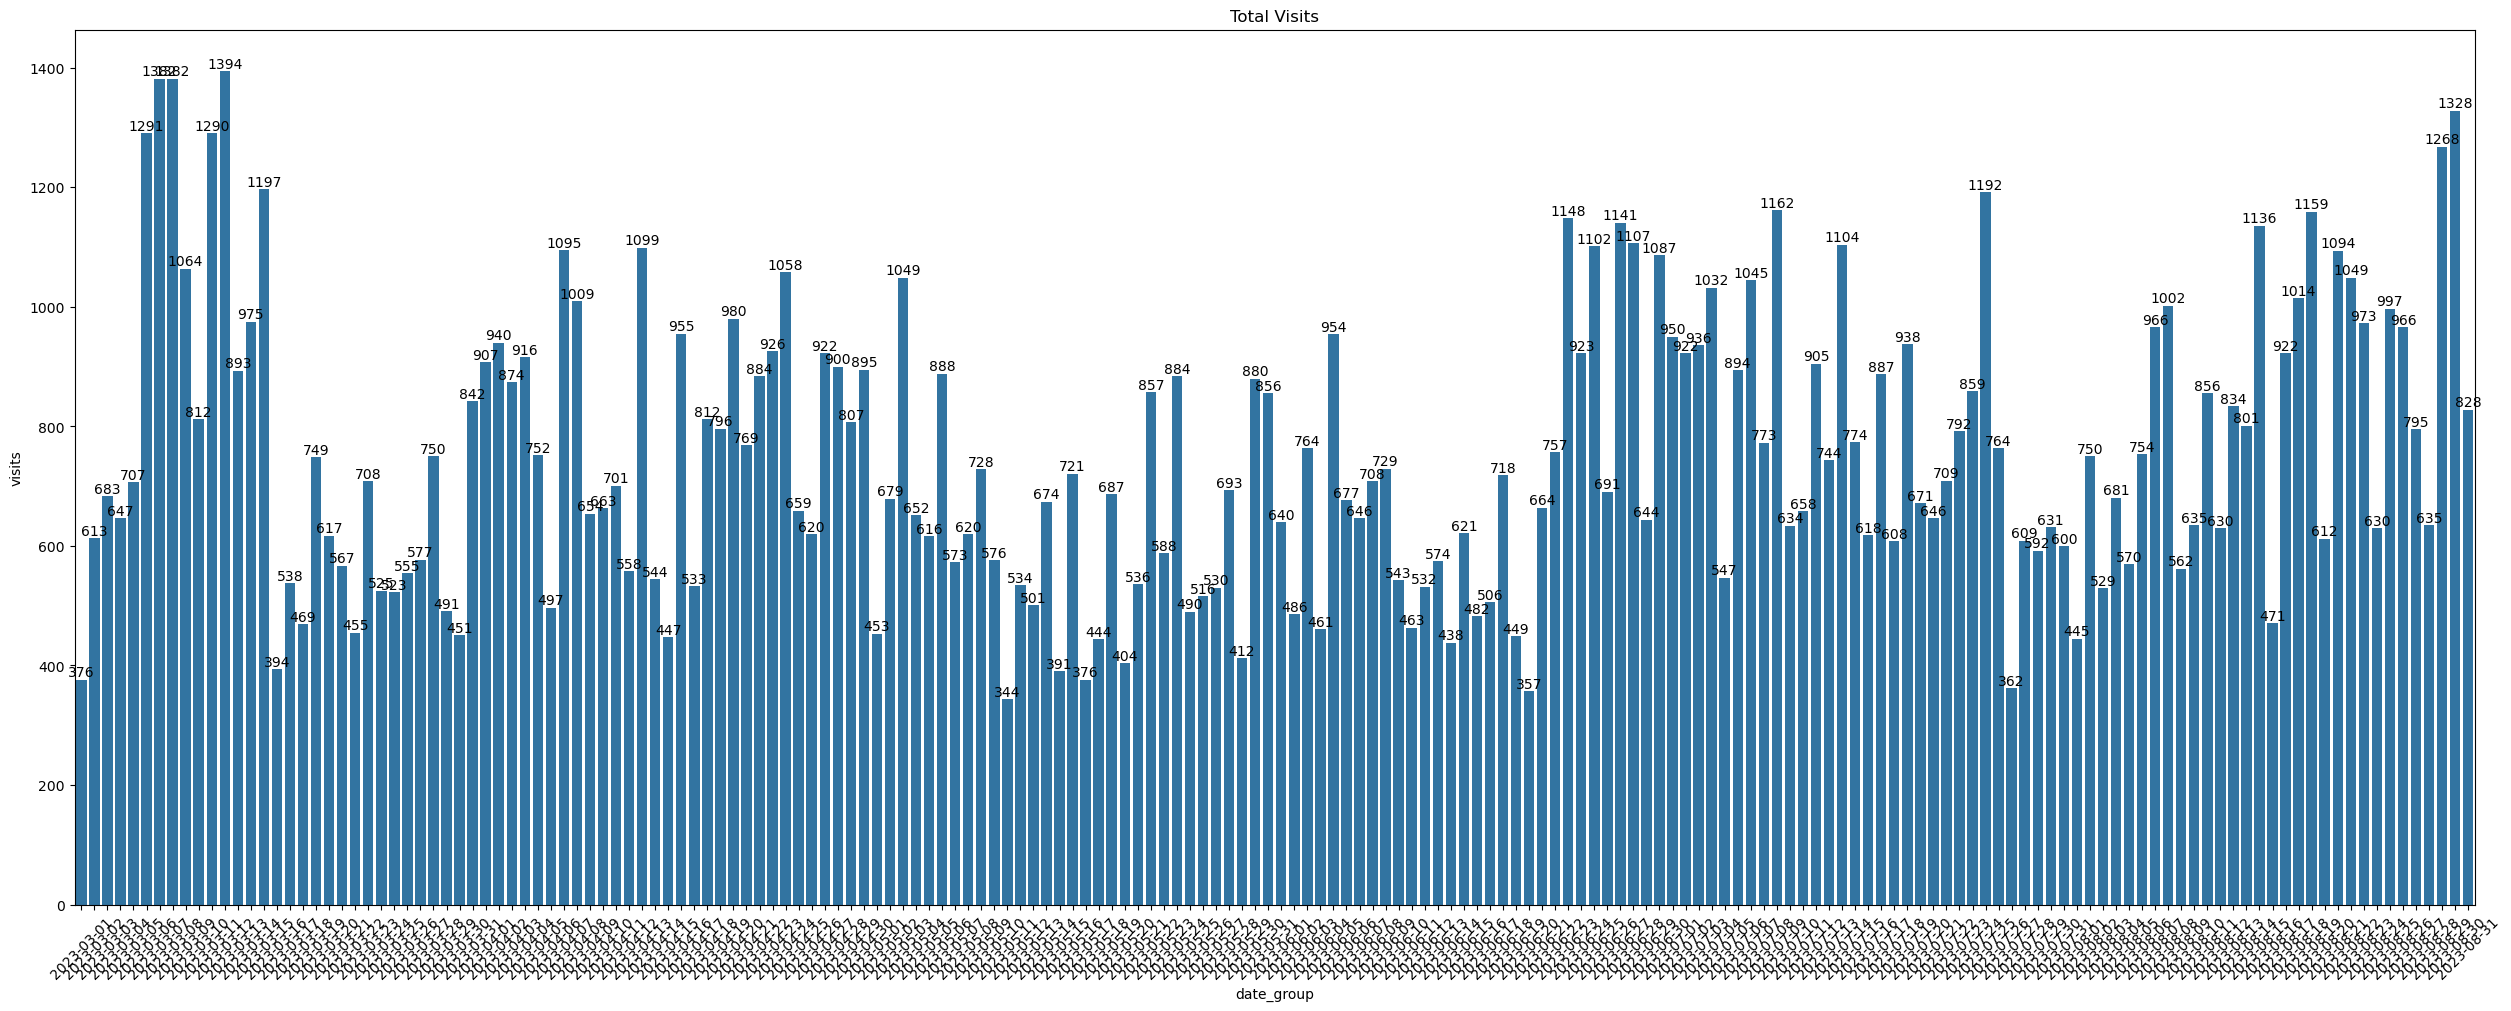

In [665]:
#строим столбчатую диаграмму визитов с разбивкой по дате
plt.figure(num=None, layout='constrained',figsize=(25,10))
total_visits = sns.barplot(data=res_df, x='date_group', y='visits')
total_visits.bar_label(total_visits.containers[0], fontsize=10);
plt.title('Total Visits')
plt.xticks(rotation=45)
plt.show()
fig_total_visits = total_visits.get_figure()
fig_total_visits.savefig('./charts/visits_by_date.png')

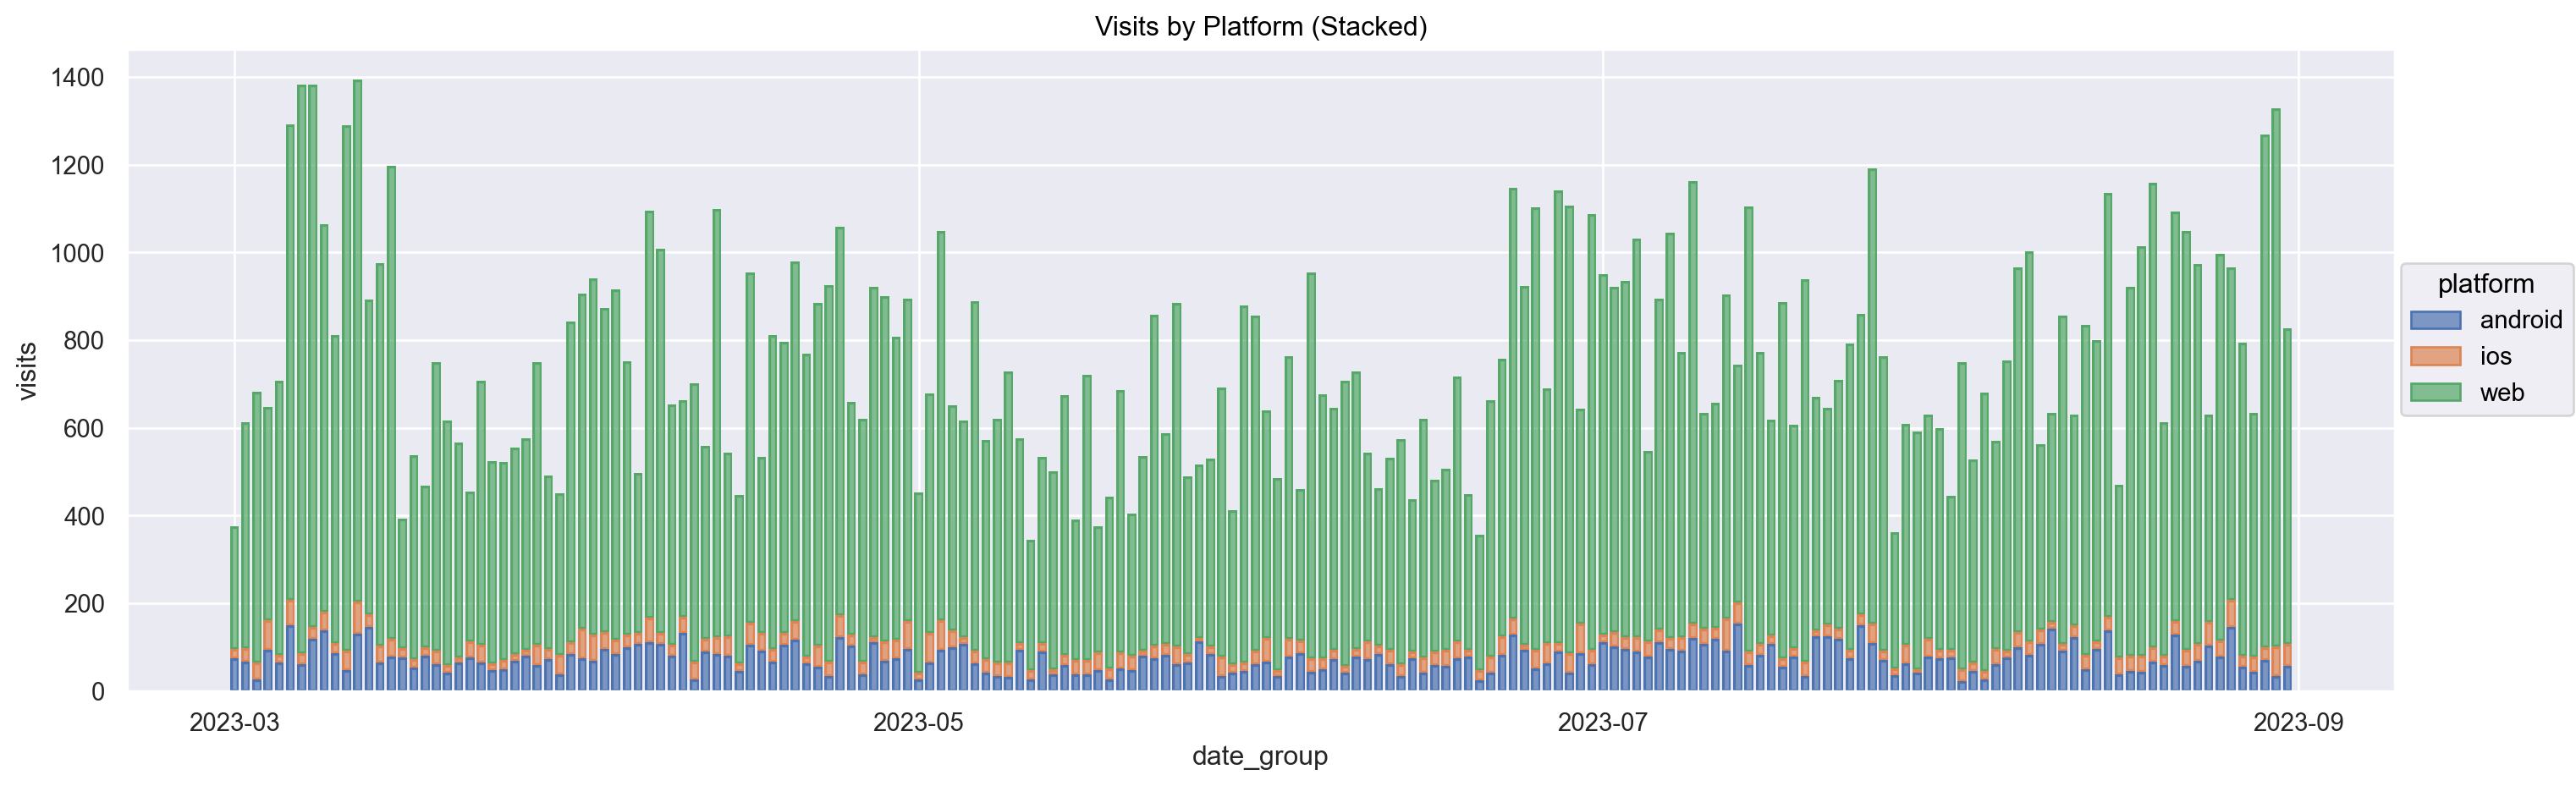

In [666]:
#строим столбчатую диаграмму визитов с разбивкой по дате и платформам
stacked_visits = res_conversion.drop(columns=['registrations', 'conversion'])
vis_by_platform = so.Plot(stacked_visits, x="date_group", y = 'visits', color="platform").add(so.Bar(), so.Stack()).layout(size=(15,5)).label(title='Visits by Platform (Stacked)')
vis_by_platform.save('./charts/visits_by_platform.png')

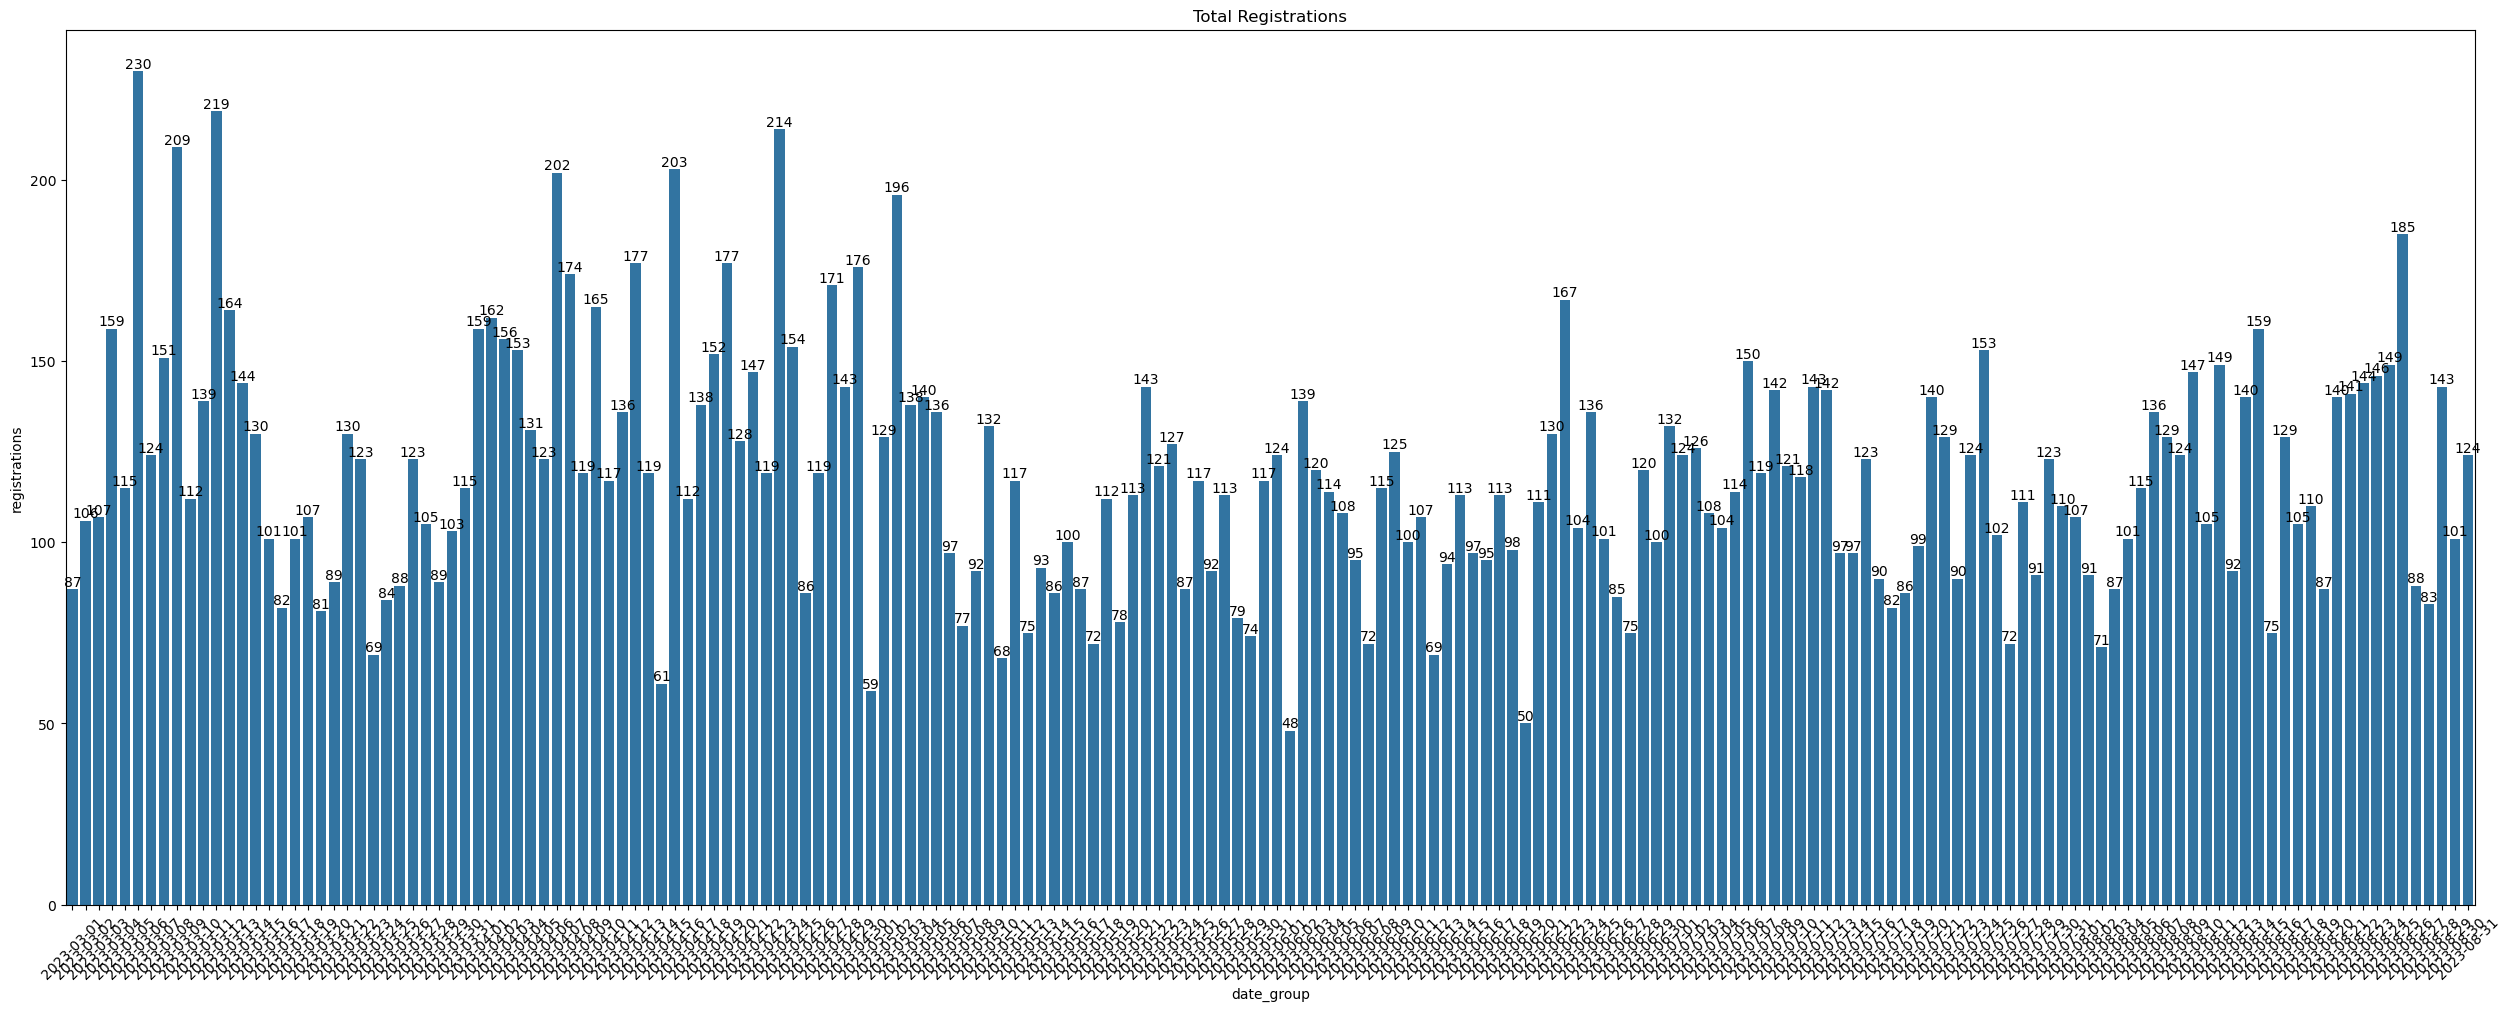

In [667]:
#строим столбчатую диаграмму регистраций с разбивкой по дате
plt.figure(num=None, layout='constrained',figsize=(25,10))
total_regs = sns.barplot(data=res_df, x='date_group', y='registrations')
total_regs.bar_label(total_regs.containers[0], fontsize=10);
plt.title('Total Registrations')
plt.xticks(rotation=45)
plt.show()
fig_total_regs = total_regs.get_figure()
fig_total_regs.savefig('./charts/registrations_by_date.png')

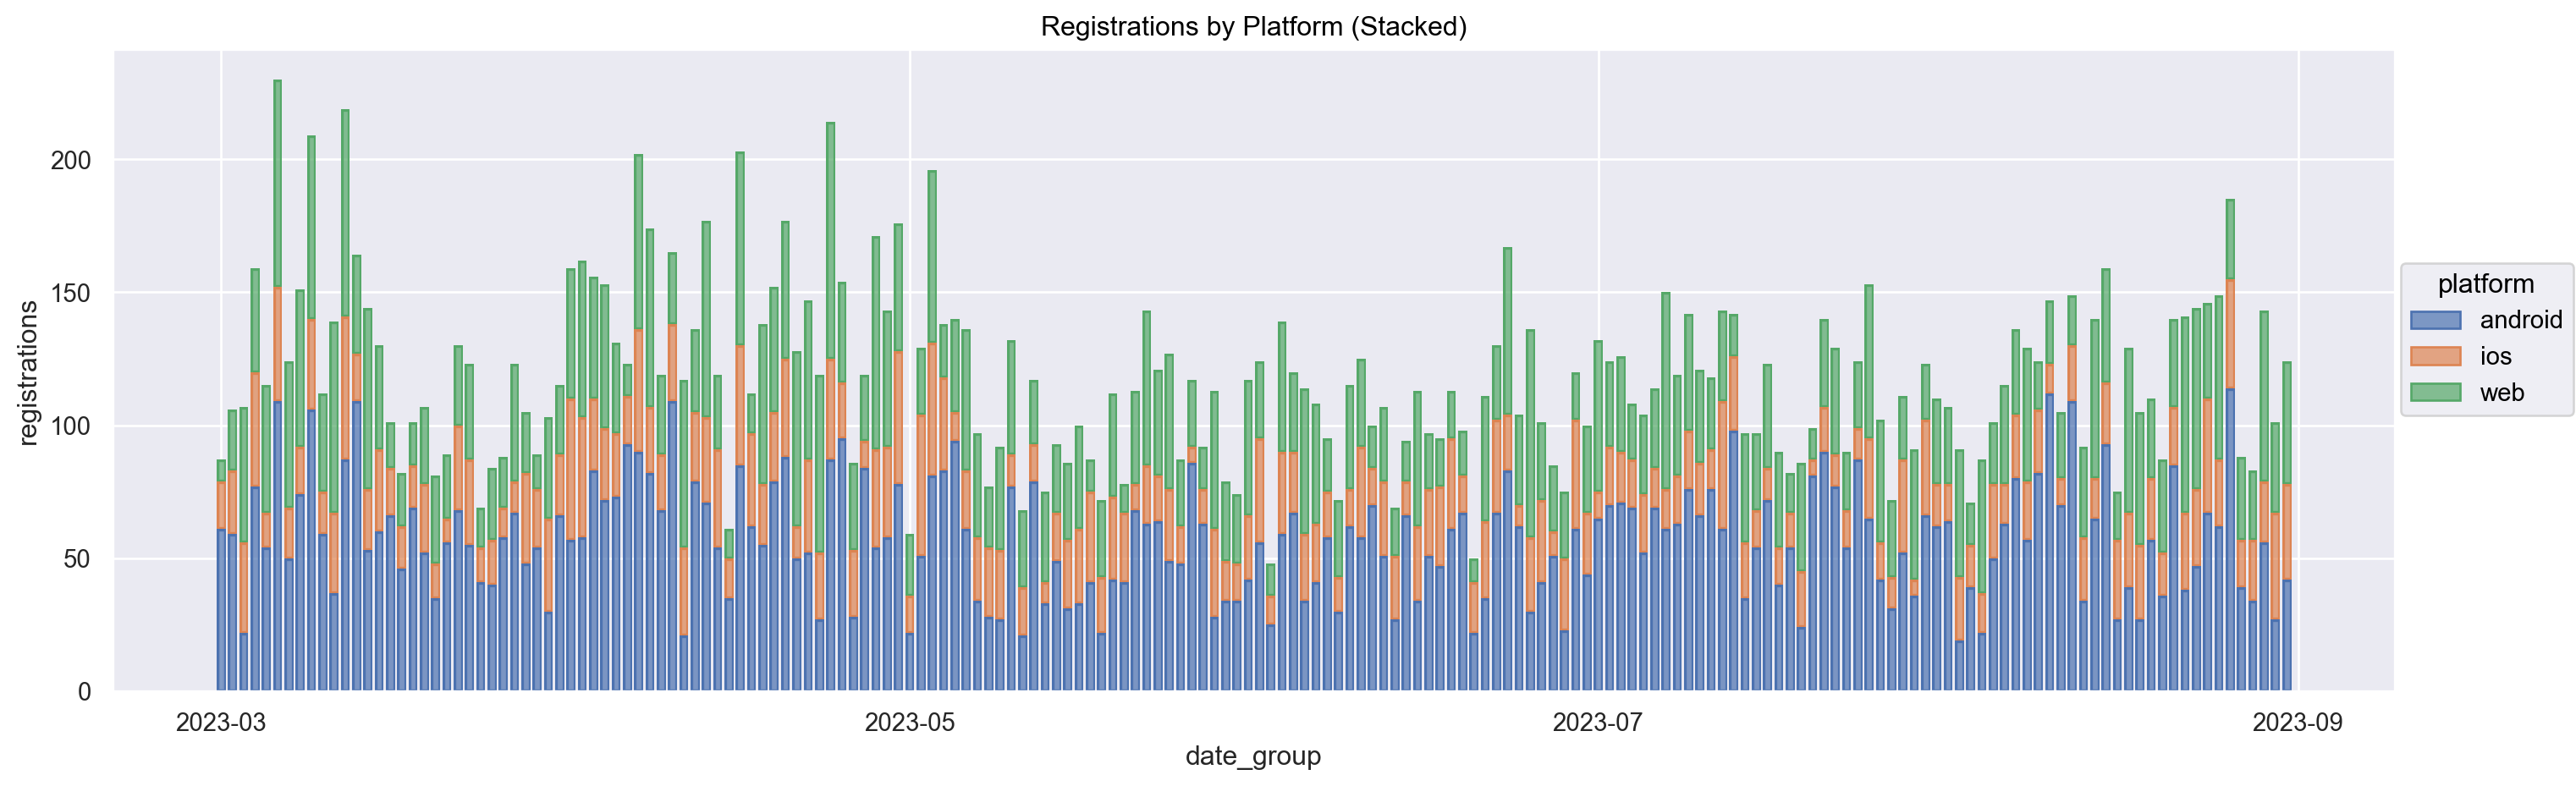

In [668]:
#строим столбчатую диаграмму регистраций с разбивкой по дате и платформам
stacked_regs = res_conversion.drop(columns=['visits', 'conversion'])
regs_by_platform = so.Plot(stacked_regs, x="date_group", y = 'registrations', color="platform").add(so.Bar(), so.Stack()).layout(size=(15,5)).label(title='Registrations by Platform (Stacked)')
regs_by_platform.save('./charts/registrations_by_platform.png')

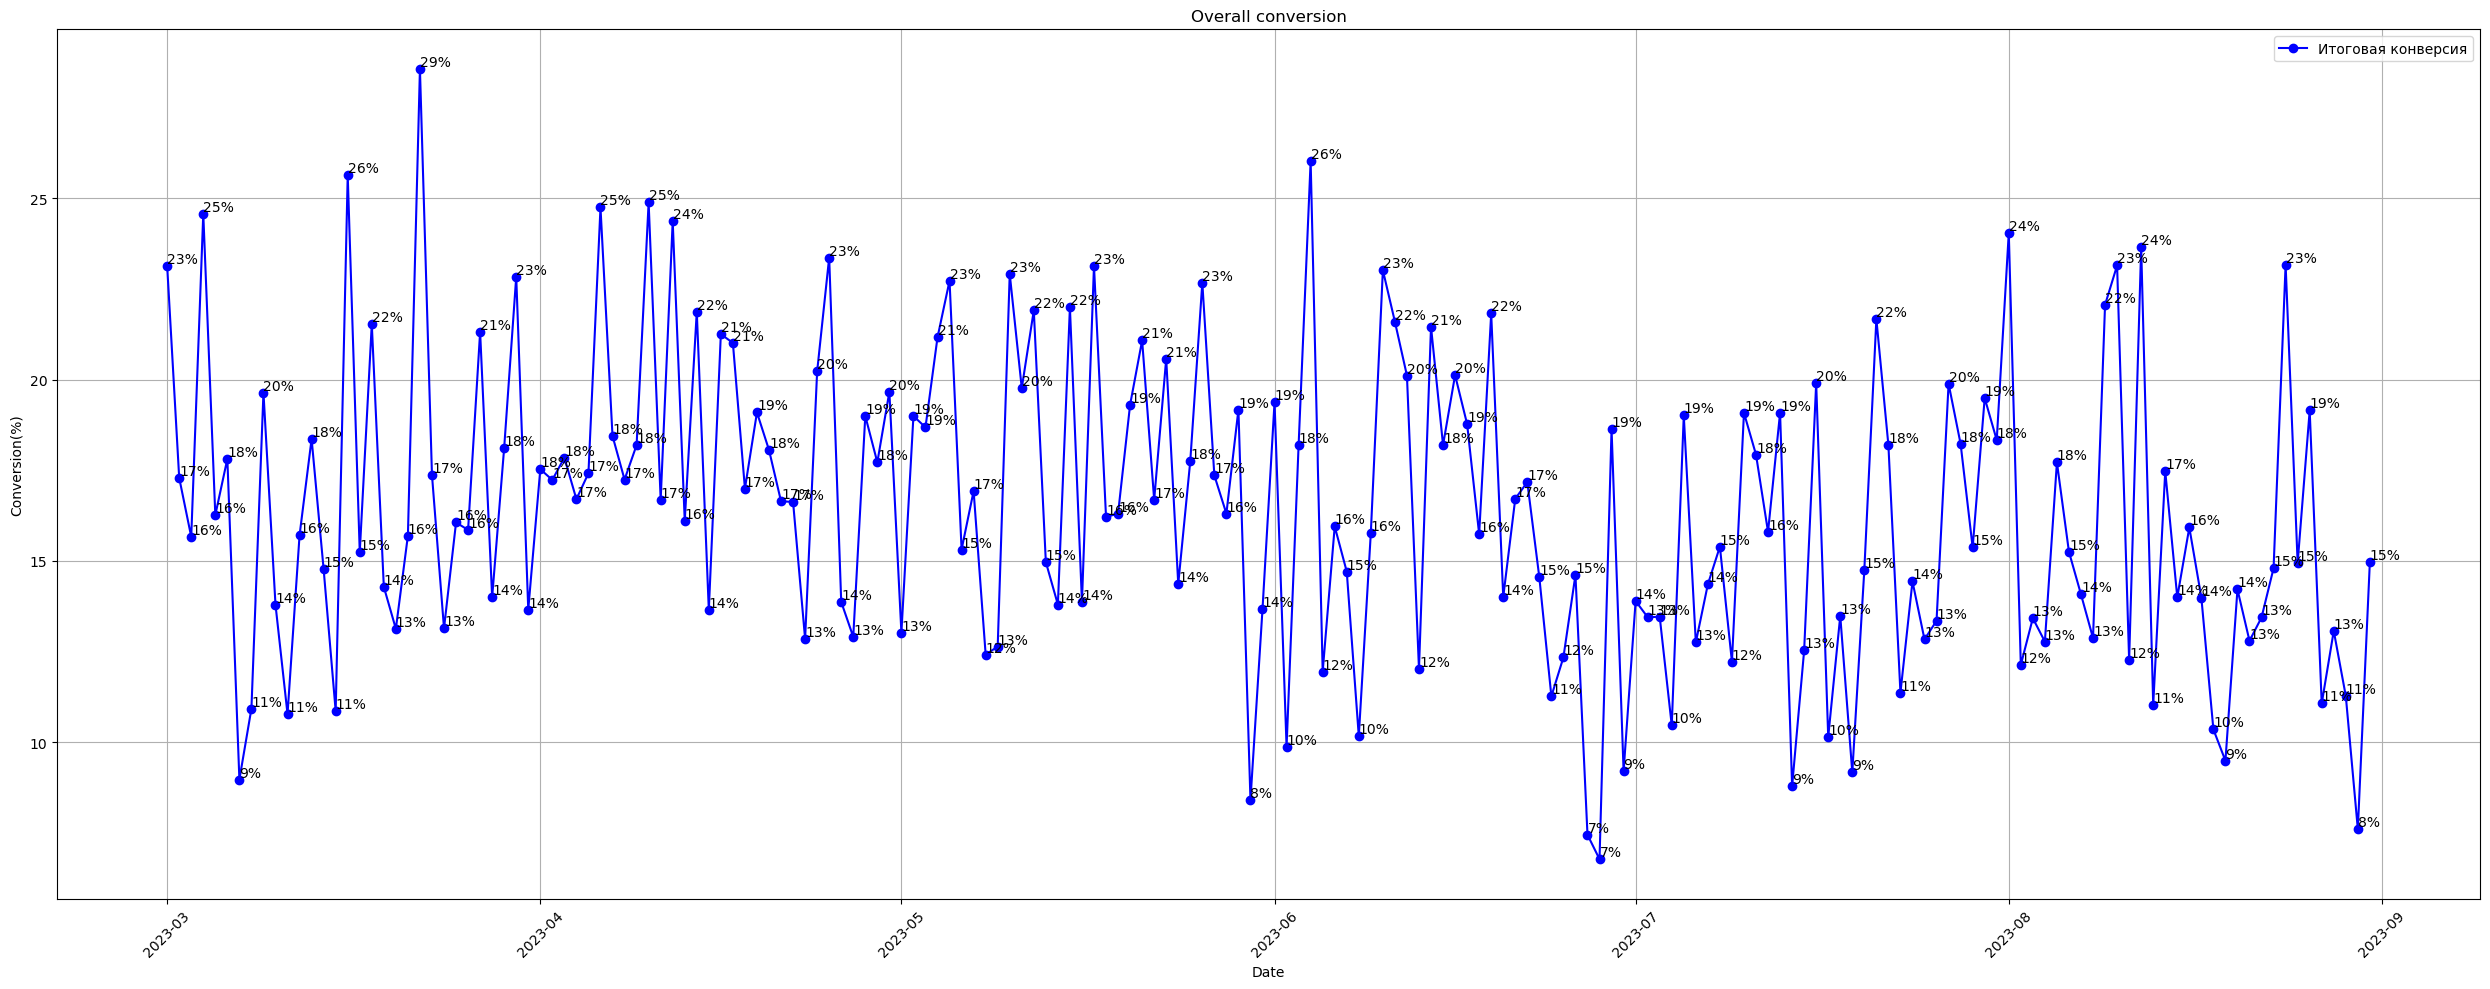

In [669]:
#подготовим данные для построения графика общей конверсии
overall_conversion = res_conversion.drop(columns=['platform', 'conversion'])
overall_conversion = overall_conversion.groupby('date_group').agg(visits = ('visits', 'sum'), registrations = ('registrations', 'sum'))
overall_conversion['conversion'] = overall_conversion['registrations'] / overall_conversion['visits'] * 100
overall_conversion = overall_conversion.drop(columns=['visits', 'registrations'])
#строим линейный график итоговой конверсии
plt.figure(figsize=(25,10))
plt.plot(overall_conversion.index, overall_conversion.values, marker='o', color='blue', label='Итоговая конверсия')
plt.title('Overall conversion')
plt.xlabel('Date')
plt.ylabel('Conversion(%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
for x,y in zip(overall_conversion.index, overall_conversion.values):
    plt.text(x, y, f'{round(y[0])}%', ha='left', va='bottom')
plt.tight_layout()
plt.savefig('./charts/overall_conversion.png')
plt.show()

In [670]:
#найдем все платформы
platforms = res_conversion['platform'].unique()

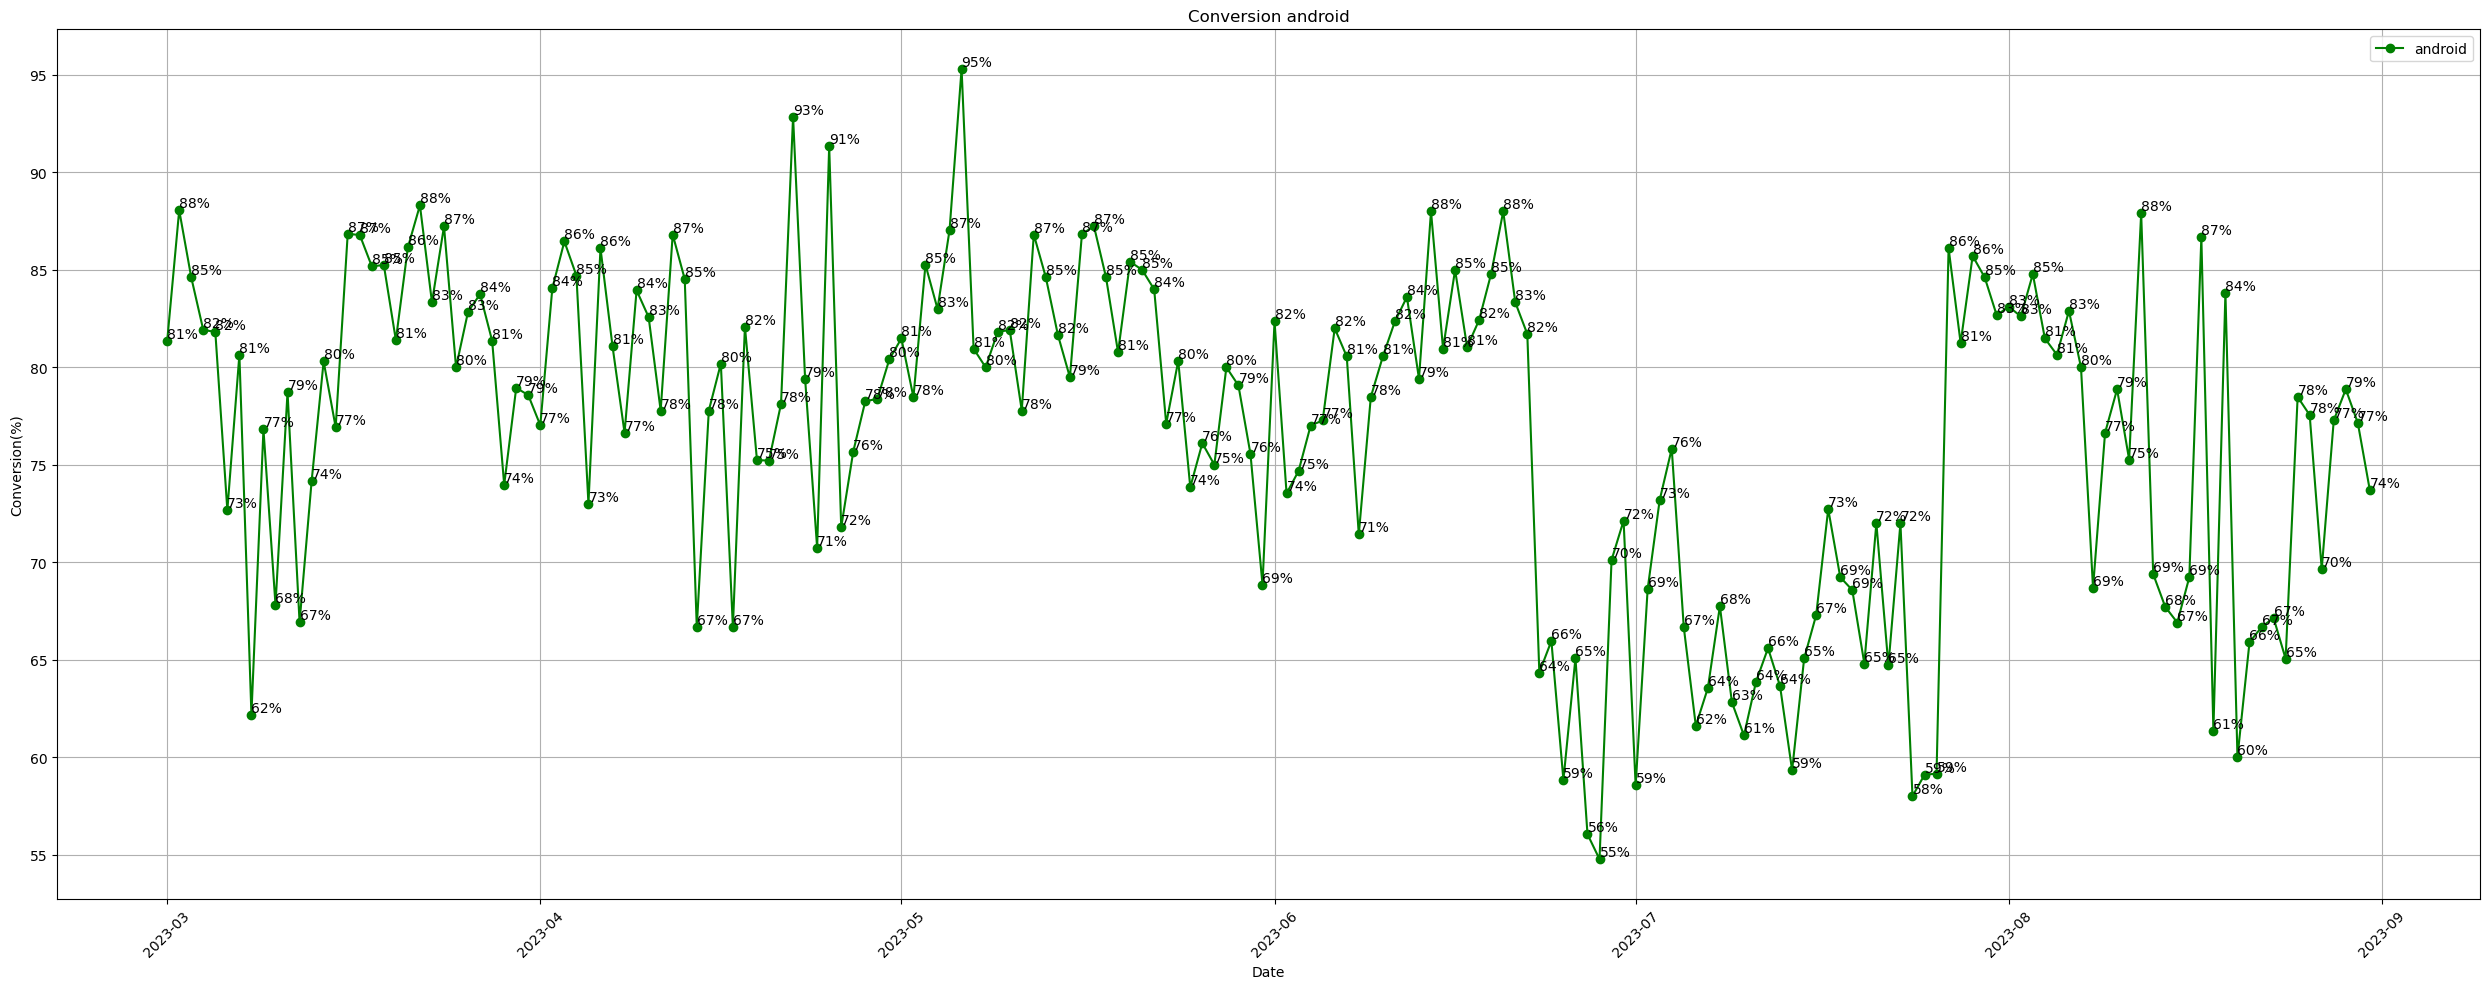

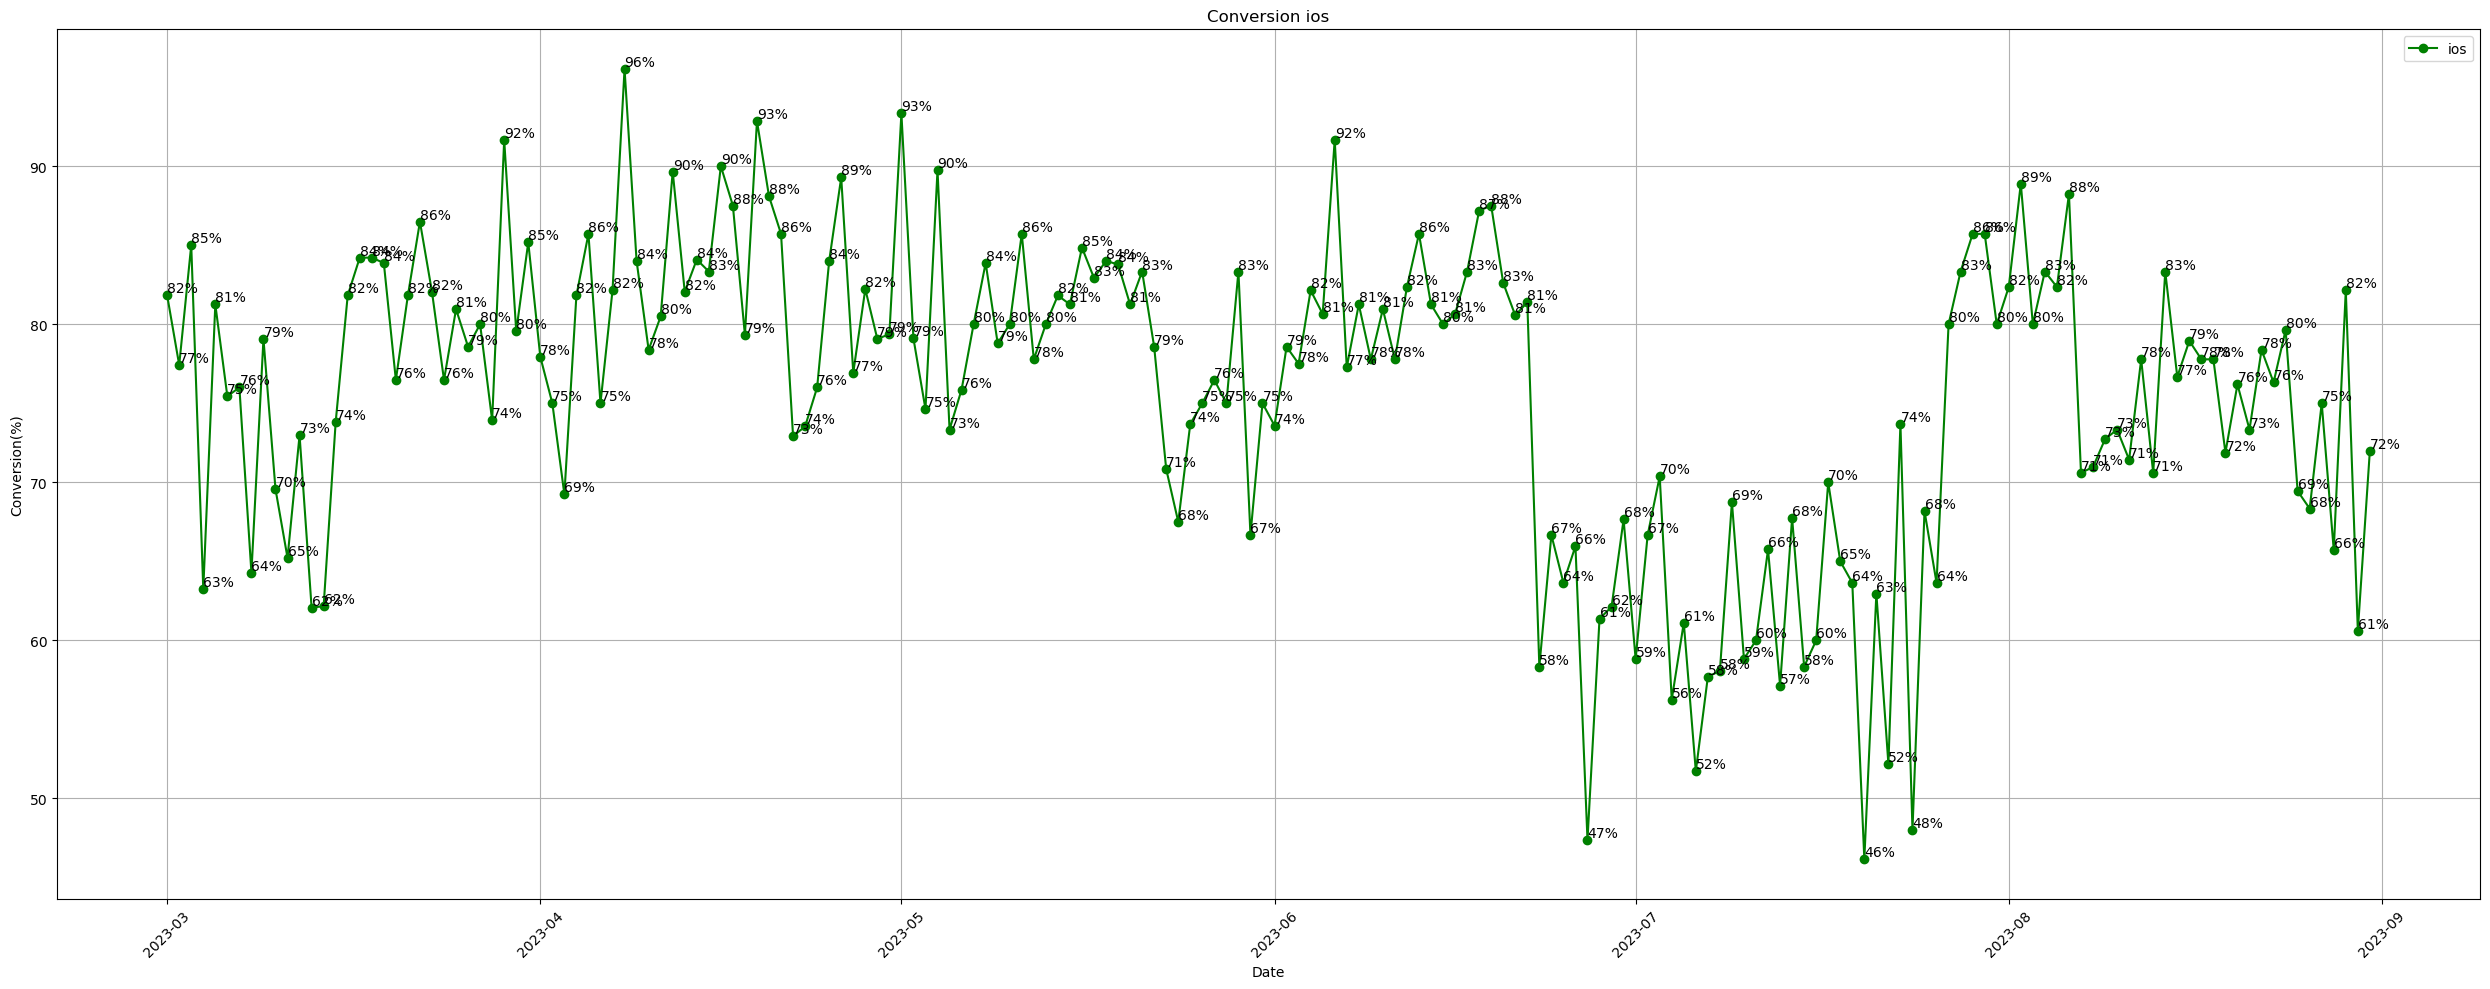

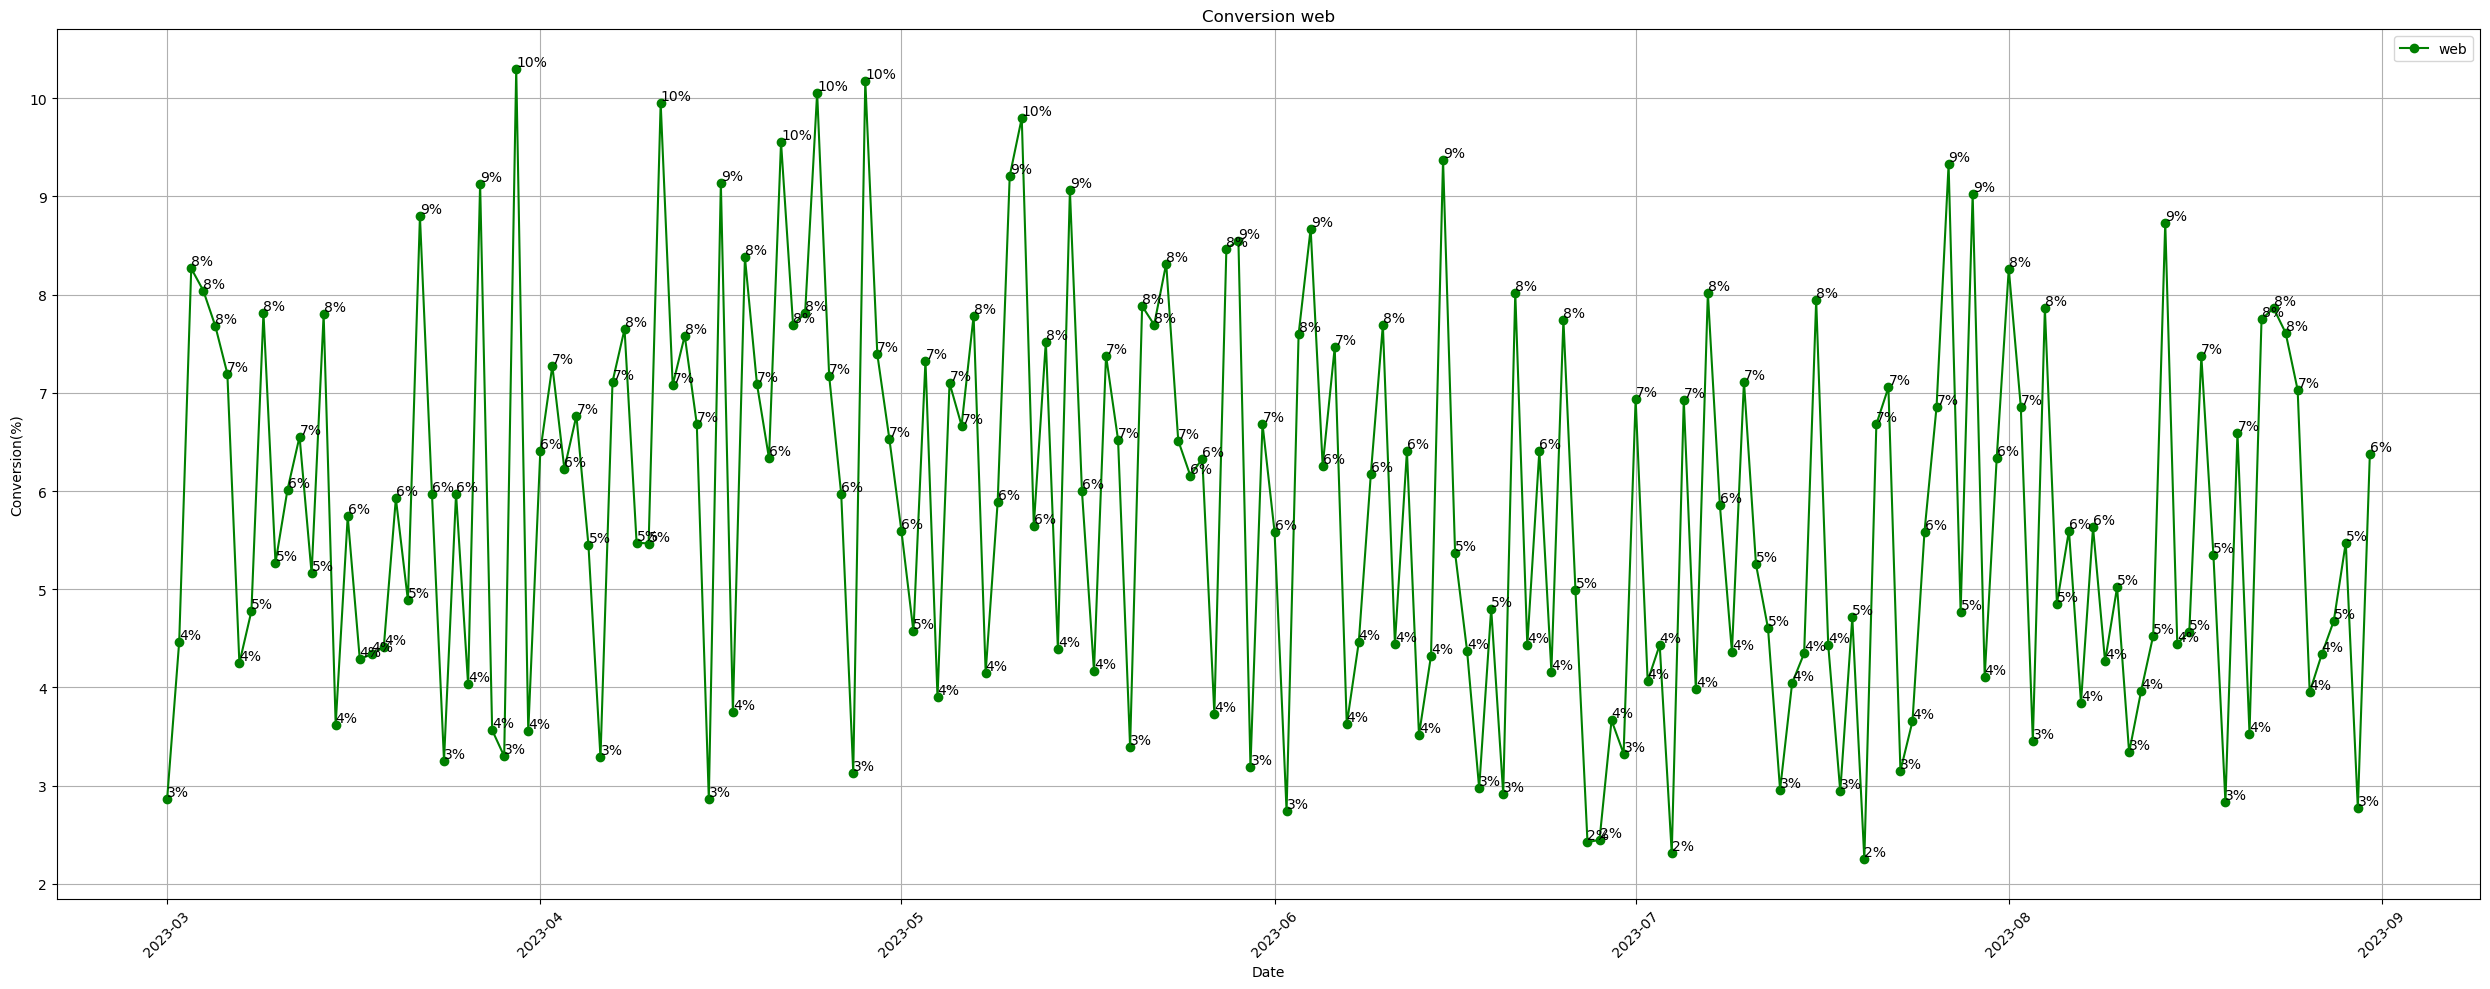

In [671]:
for p in platforms:
    #подготовка данных для построения графика
    platform_conversion = res_conversion[res_conversion['platform'] == p].drop(columns=['platform', 'visits', 'registrations'])
    platform_conversion = platform_conversion.groupby('date_group').sum()
    #строим линеный график конверсии по платформе
    plt.figure(figsize=(25,10))
    plt.plot(platform_conversion.index, platform_conversion.values, marker='o', color='green', label=p)
    plt.title(f'Conversion {p}')
    plt.xlabel('Date')
    plt.ylabel('Conversion(%)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    for x,y in zip(platform_conversion.index, platform_conversion.values):
        plt.text(x, y, f'{round(y[0])}%', ha='left', va='bottom')
    plt.tight_layout()
    plt.savefig(f'./charts/{p}_conversion.png')
    plt.show()

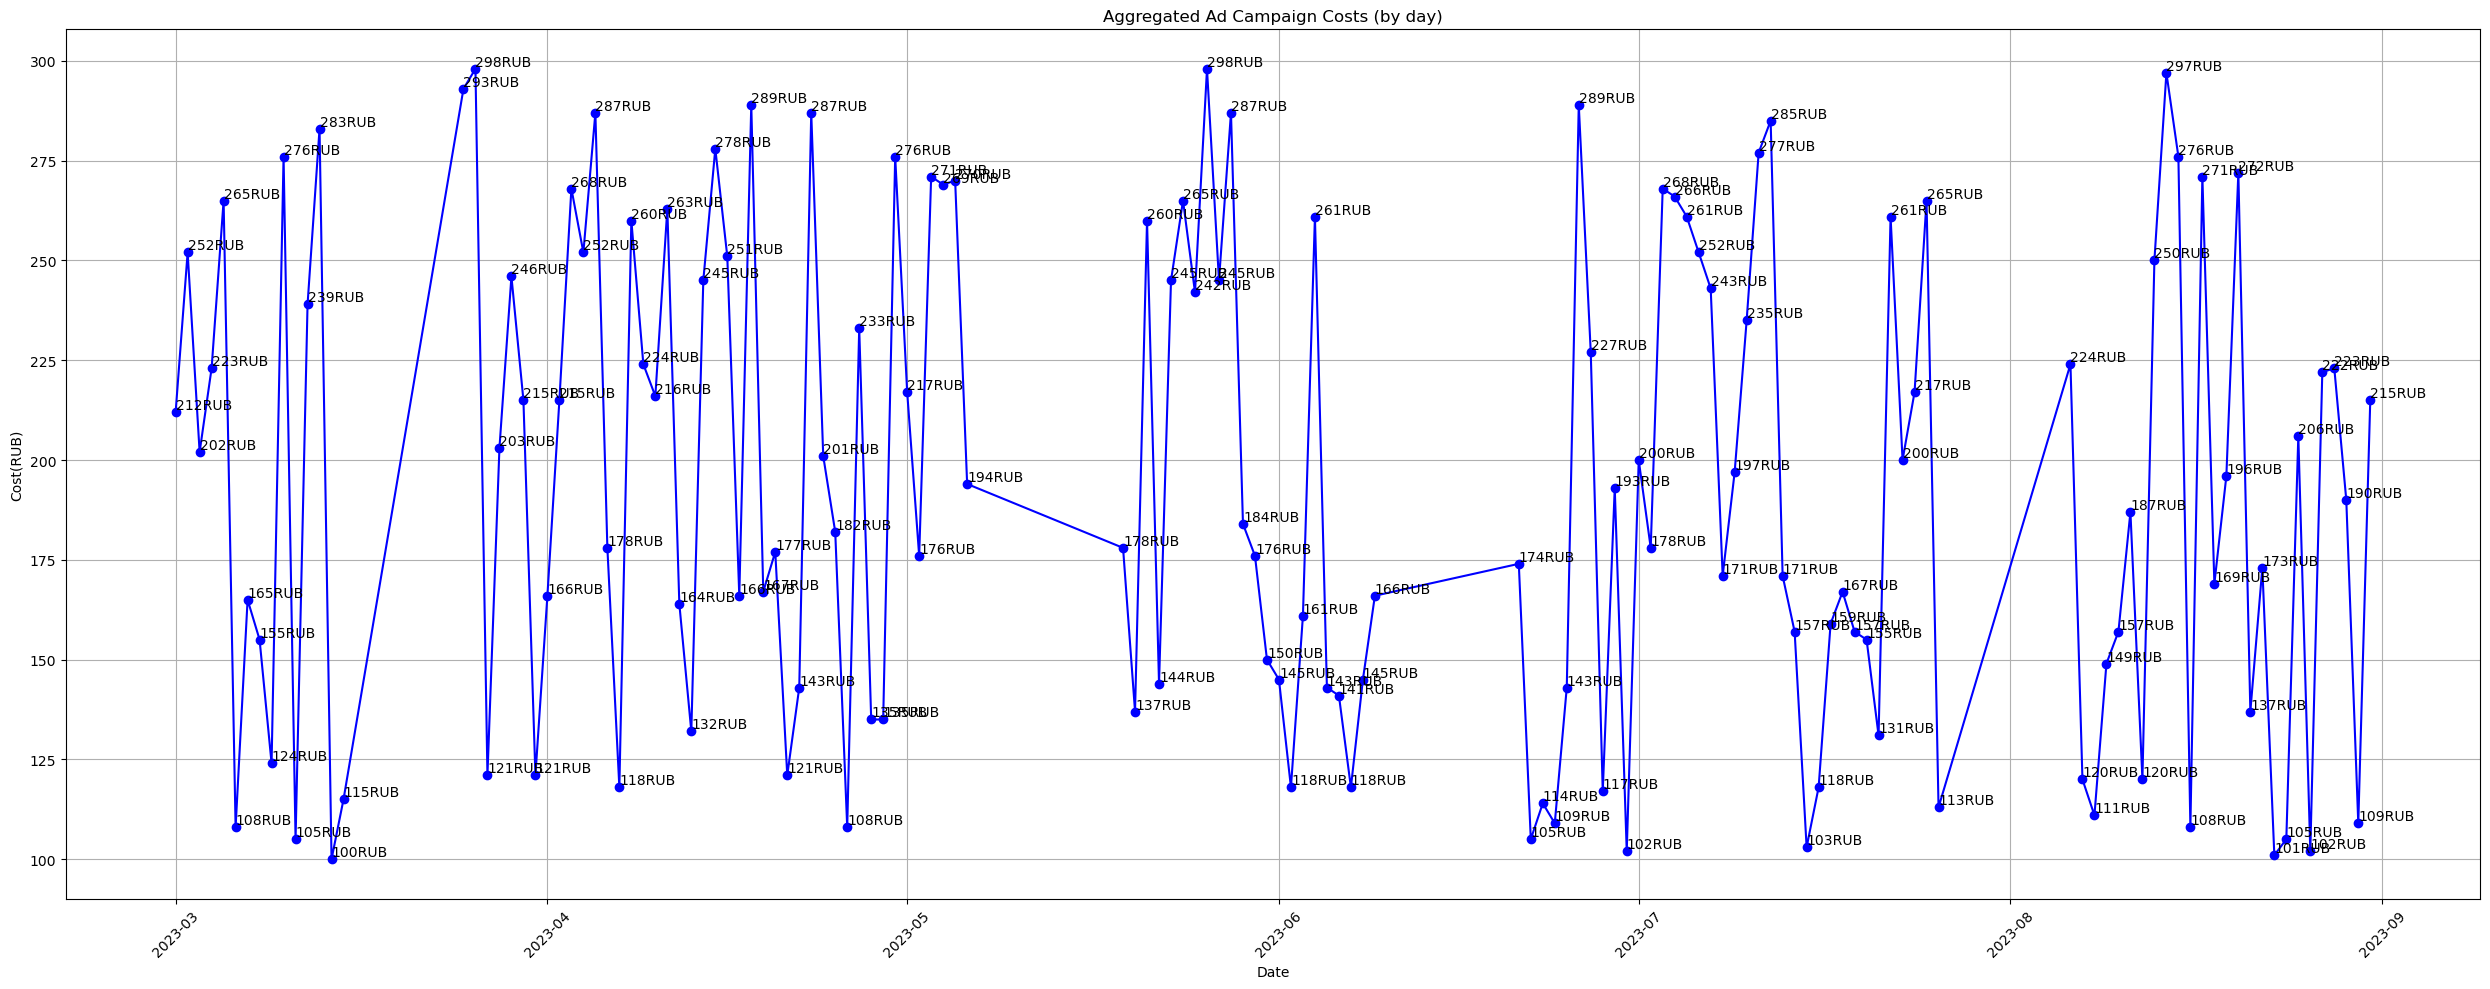

In [672]:
#подготовим данные для построения графика затрат на рекламу
ads_cost = res_ads.drop(columns=['visits', 'registrations', 'utm_campaign'])
ads_cost = ads_cost[ads_cost['cost'] > 0]
ads_cost = ads_cost.groupby('date_group').sum()
#строим линейный график затрат на рекламу
plt.figure(figsize=(25,10))
plt.plot(ads_cost.index, ads_cost.values, marker='o', color='blue')
plt.title('Aggregated Ad Campaign Costs (by day)')
plt.xlabel('Date')
plt.ylabel('Cost(RUB)')
plt.xticks(rotation=45)
plt.grid(True)
for x,y in zip(ads_cost.index, ads_cost.values):
    plt.text(x, y, f'{round(y[0])}RUB', ha='left', va='bottom')
plt.tight_layout()
plt.savefig('./charts/ads_cost.png')
plt.show()

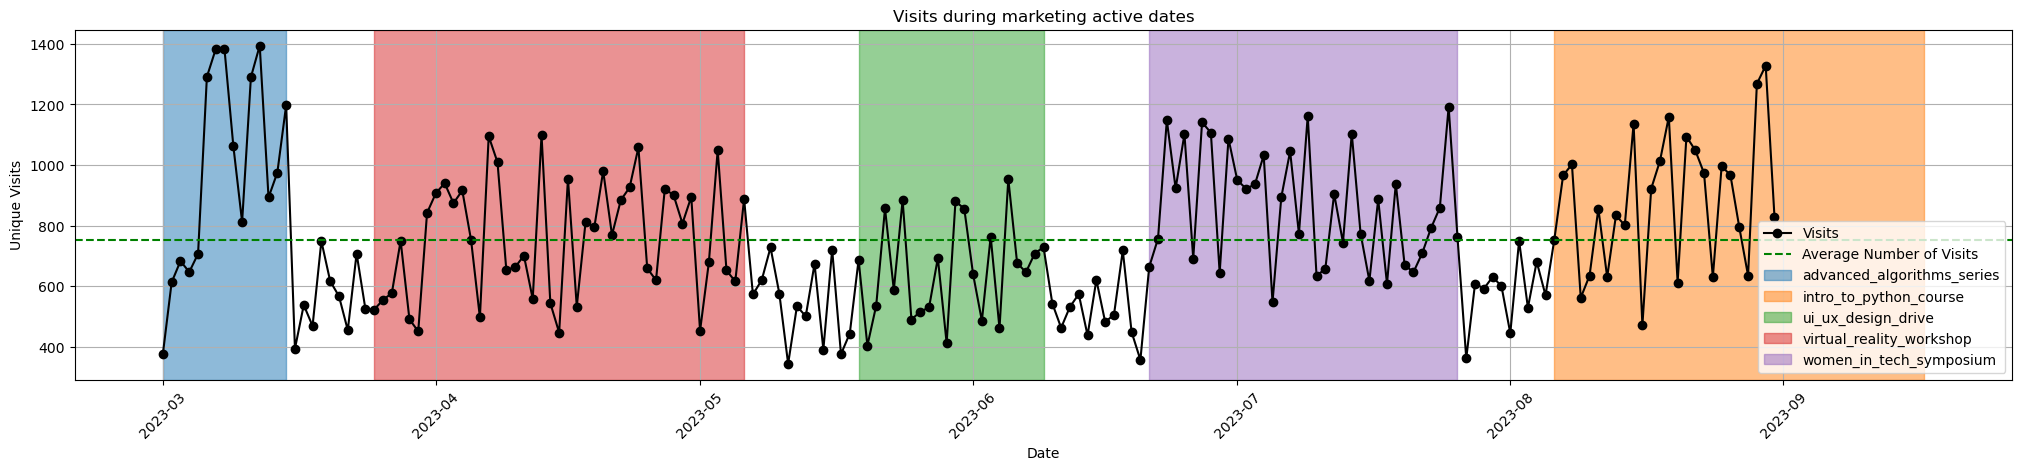

In [673]:
#построим график посещений в дни рекламных кампаний
plt.figure(figsize=(25,10))
campaign_colors = dict(zip(campaign_periods['utm_campaign'].unique(), plt.cm.tab10.colors[:len(campaign_periods['utm_campaign'].unique())]))
plt.subplot(2, 1, 1)
plt.plot(res_ads['date_group'], res_ads['visits'], marker='o', color='black', label='Visits')
plt.axhline(y=np.nanmean(res_ads.visits), linestyle='dashed', color='green', label='Average Number of Visits')
for _,row in campaign_periods.iterrows():
    plt.axvspan(row['start'], row['end'], label=row['utm_campaign'], color=campaign_colors[row['utm_campaign']], alpha=0.5)
plt.title('Visits during marketing active dates')
plt.xlabel('Date')
plt.ylabel('Unique Visits')
plt.xticks(rotation=45)
plt.grid(True)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('./charts/ads_visits.png')
plt.show()

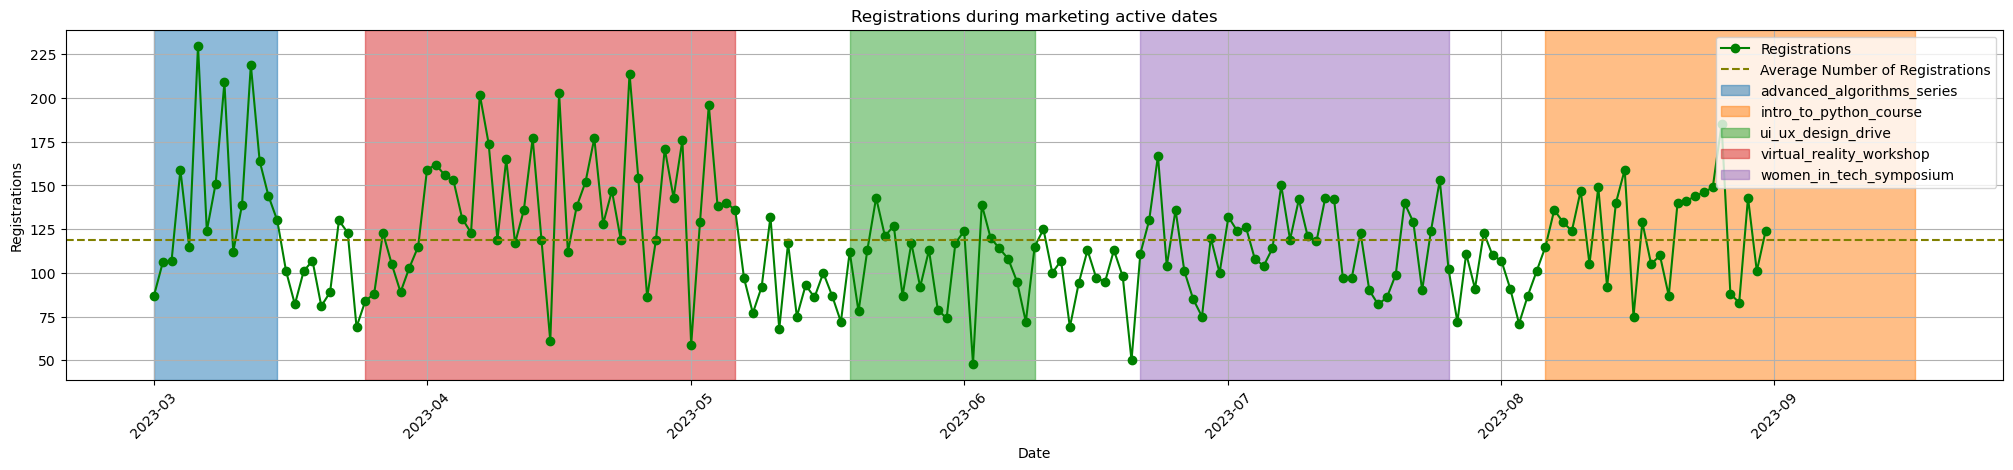

In [674]:
#построим график регистраций в дни рекламных кампаний
plt.figure(figsize=(25,10))
campaign_colors = dict(zip(campaign_periods['utm_campaign'].unique(), plt.cm.tab10.colors[:len(campaign_periods['utm_campaign'].unique())]))
plt.subplot(2, 1, 1)
plt.plot(res_ads['date_group'], res_ads['registrations'], marker='o', color='green', label='Registrations')
plt.axhline(y=np.nanmean(res_ads.registrations), linestyle='dashed', color='olive', label='Average Number of Registrations')
for _,row in campaign_periods.iterrows():
    plt.axvspan(row['start'], row['end'], label=row['utm_campaign'], color=campaign_colors[row['utm_campaign']], alpha=0.5)
plt.title('Registrations during marketing active dates')
plt.xlabel('Date')
plt.ylabel('Registrations')
plt.xticks(rotation=45)
plt.grid(True)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('./charts/ads_registrations.png')
plt.show()